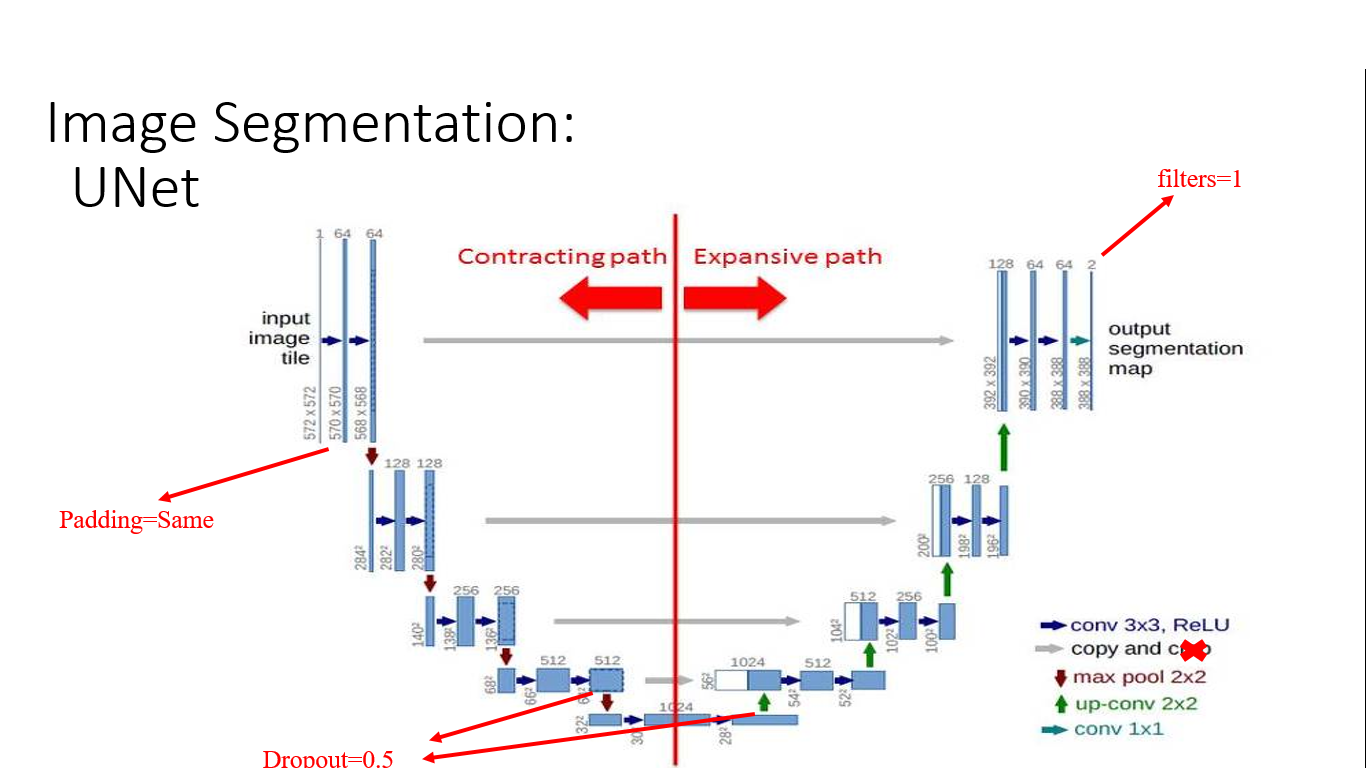

In [1]:
from IPython.display import Image
Image(filename="UNet.png")

In [3]:
import numpy as np

from skimage import io
from skimage import transform

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, MaxPooling2D, Dropout
from keras.layers import Conv2D, UpSampling2D, concatenate, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

In [4]:
def adjust_data(img, mask):
    img = img/255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask

In [5]:
def get_train_generator(batch_size,
                        train_path,
                        image_folder,
                        mask_folder,
                        aug_dict,
                        image_color_mode = "grayscale",
                        mask_color_mode = "grayscale",
                        image_save_prefix  = "image",
                        mask_save_prefix  = "mask",
                        save_to_dir = None,
                        target_size = (256,256),
                        seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results
    of generator, set save_to_dir = "your path"
    '''

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None, # no labels will be returned
        color_mode = image_color_mode,
        target_size = target_size, # The dimensions to which all images found will be resized
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        seed = seed # random seed for shuffling and transformations
    )

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode= None, # no labels will be returned
        color_mode = image_color_mode,
        target_size = target_size, # The dimensions to which all images found will be resized
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = mask_save_prefix,
        seed=seed # random seed for shuffling and transformations
    )

    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = adjust_data(img, mask)
        yield img, mask

In [6]:
def get_test_generator(test_path, num_images=30, target_size=(256,256), as_gray=True):
    for i in range(num_images):
        img = io.imread(os.path.join(test_path,f"{i}.png"), as_gray = as_gray)
        img = img / 255
        img = transform.resize(img, target_size)
        img = np.reshape(img,(1,) + img.shape + (1,))
        yield img

In [9]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')
generator = get_train_generator(batch_size=20,
                                train_path='./data/membrane/train',
                                image_folder='image',
                                mask_folder='label',
                                aug_dict=data_gen_args,
                                save_to_dir = "./data/membrane/train/aug" )
num_batch = 3
for i, batch in enumerate(generator):
    if i >= num_batch:
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


In [10]:
# create model
def unet(pretrained_weights = None, input_shape=(256, 256, 1)):
    pass

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')
generator = get_train_generator(batch_size=2,
                                train_path='data/membrane/train',
                                image_folder='image',
                                mask_folder='label',
                                aug_dict=data_gen_args,
                                save_to_dir=None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)
model.fit_generator(generator,
                    steps_per_epoch=2000,
                    epochs=5,
                    callbacks=[model_checkpoint])


In [ ]:
# test your model and save predicted results
test_generator = get_test_generator("./data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(test_generator,30,verbose=1)

In [ ]:
for i, item in enumerate(results):
    img =  item[:,:,0]
    io.imsave(os.path.join("./data/membrane/test","%d_predict.png"%i),img)

Source Address:

https://github.com/zhixuhao/unet